In [1]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os

# Add src directory to path
sys.path.append('../src')

# Import custom modules
from data_processing import (
    load_csv_numpy, check_missing_values, handle_missing_values,
    detect_outliers_zscore, detect_outliers_iqr,
    normalize_minmax, normalize_log, standardize_zscore,
    stratified_train_test_split, smote_oversample, random_undersample,
    compute_class_weights
)
from visualization import plot_class_distribution

# Set random seed
np.random.seed(42)

%matplotlib inline

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Load Data

In [2]:
# Load data
data_path = '../data/raw/creditcard.csv'

print("Loading dataset...")
data = load_csv_numpy(data_path)

# Separate features and target
X = data[:, :-1]
y = data[:, -1]

print(f"\nFeatures shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Fraud rate: {y.sum()/len(y)*100:.4f}%")

Loading dataset...
Data loaded successfully: (284807, 31)

Features shape: (284807, 30)
Target shape: (284807,)
Fraud rate: 0.1727%


## 2. Check and Handle Missing Values

In [3]:
# Check for missing values
missing_info = check_missing_values(X)

if missing_info['total'] > 0:
    print("\nHandling missing values...")
    X = handle_missing_values(X, strategy='median')
    print("Missing values handled")
else:
    print("\nNo missing values to handle")

Total missing values: 0
Missing percentage: 0.0000%

No missing values to handle


## 3. Outlier Detection

Detect outliers but DO NOT remove them (fraud cases might appear as outliers).

In [4]:
# Detect outliers using Z-score method
print("Detecting outliers (Z-score method, threshold=3)...")
outlier_mask_zscore = detect_outliers_zscore(X, threshold=3)

print("\nDetecting outliers (IQR method, multiplier=1.5)...")
outlier_mask_iqr = detect_outliers_iqr(X, multiplier=1.5)

# Check if fraud cases are among outliers
fraud_mask = y == 1
fraud_as_outliers_zscore = np.sum(outlier_mask_zscore & fraud_mask)
fraud_as_outliers_iqr = np.sum(outlier_mask_iqr & fraud_mask)

print(f"\nFraud cases detected as outliers (Z-score): {fraud_as_outliers_zscore}/{fraud_mask.sum()}")
print(f"Fraud cases detected as outliers (IQR): {fraud_as_outliers_iqr}/{fraud_mask.sum()}")
print("\nWe will NOT remove outliers as they may contain fraud cases!")

Detecting outliers (Z-score method, threshold=3)...
Outliers detected: 37816 (13.28%)

Detecting outliers (IQR method, multiplier=1.5)...
IQR Outliers detected: 138473 (48.62%)

Fraud cases detected as outliers (Z-score): 444/492
Fraud cases detected as outliers (IQR): 477/492

We will NOT remove outliers as they may contain fraud cases!


## 4. Feature Scaling

### 4.1 Standardization (Z-score normalization)

Formula: $x_{std} = \frac{x - \mu}{\sigma}$

This ensures mean=0 and std=1, which is important for gradient-based algorithms.

In [5]:
# Standardize features
print("Standardizing features...")
X_scaled, scaler_params = standardize_zscore(X)

print(f"\nOriginal data:")
print(f"  Mean: {X.mean():.4f}, Std: {X.std():.4f}")
print(f"  Range: [{X.min():.2f}, {X.max():.2f}]")

print(f"\nScaled data:")
print(f"  Mean: {X_scaled.mean():.4f}, Std: {X_scaled.std():.4f}")
print(f"  Range: [{X_scaled.min():.2f}, {X_scaled.max():.2f}]")

print("\n Standardization complete")

Standardizing features...

Original data:
  Mean: 3163.4070, Std: 19100.2968
  Range: [-113.74, 172792.00]

Scaled data:
  Mean: 0.0000, Std: 1.0000
  Range: [-82.41, 102.54]

 Standardization complete


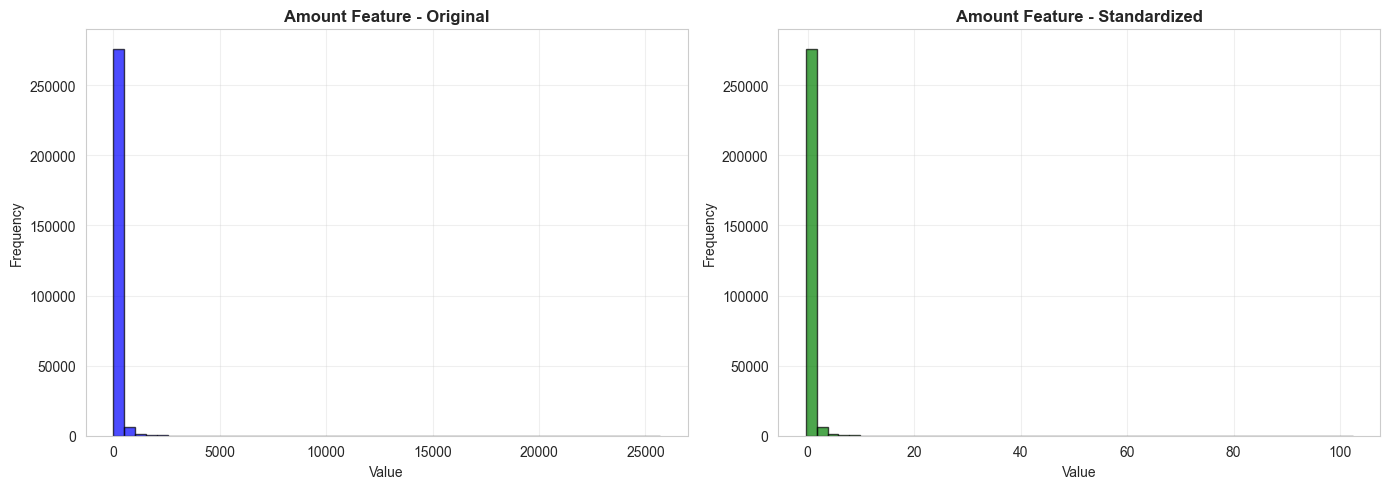

In [6]:
# Visualize scaling effect on a sample feature
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Original
axes[0].hist(X[:, -1], bins=50, color='blue', alpha=0.7, edgecolor='black')
axes[0].set_title('Amount Feature - Original', fontweight='bold')
axes[0].set_xlabel('Value')
axes[0].set_ylabel('Frequency')
axes[0].grid(True, alpha=0.3)

# Scaled
axes[1].hist(X_scaled[:, -1], bins=50, color='green', alpha=0.7, edgecolor='black')
axes[1].set_title('Amount Feature - Standardized', fontweight='bold')
axes[1].set_xlabel('Value')
axes[1].set_ylabel('Frequency')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Train-Test Split (Stratified)

Maintain class distribution in both train and test sets.

In [7]:
# Stratified split
print("Performing stratified train-test split (80/20)...")
X_train, X_test, y_train, y_test = stratified_train_test_split(
    X_scaled, y, test_size=0.2, random_seed=42
)

print(f"\nTraining set: {X_train.shape[0]:,} samples")
print(f"Test set: {X_test.shape[0]:,} samples")
print("\n Stratified split complete")

Performing stratified train-test split (80/20)...
Train set: (227846, 30), Test set: (56961, 30)
Train fraud rate: 0.1729%
Test fraud rate: 0.1720%

Training set: 227,846 samples
Test set: 56,961 samples

 Stratified split complete


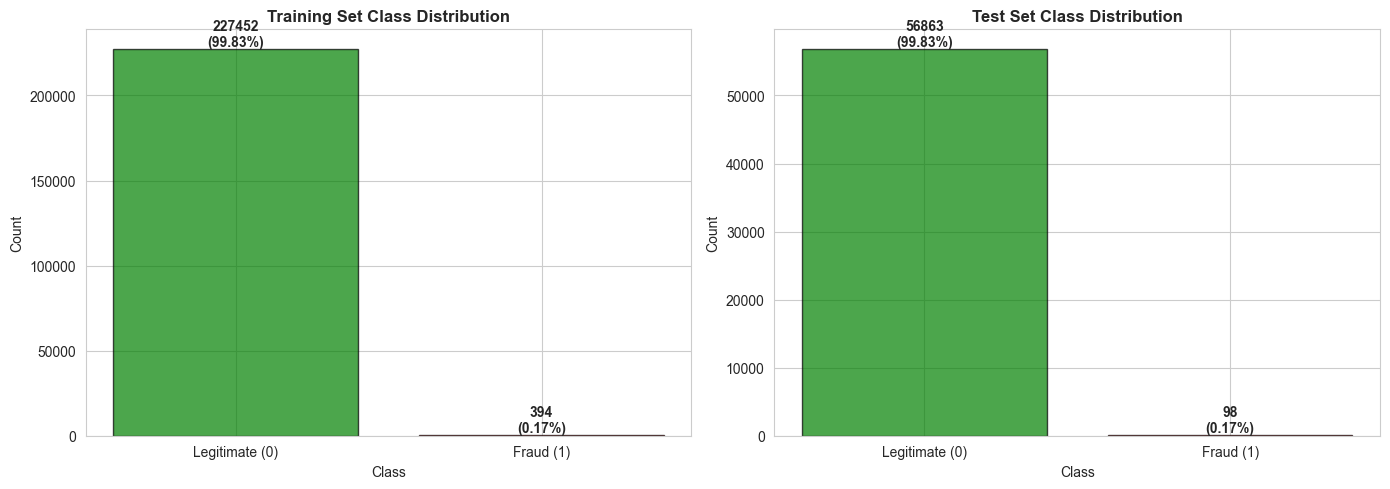

In [8]:
# Visualize class distribution in train and test sets
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training set
train_unique, train_counts = np.unique(y_train, return_counts=True)
axes[0].bar(train_unique, train_counts, color=['green', 'red'], alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Count')
axes[0].set_title('Training Set Class Distribution', fontweight='bold')
axes[0].set_xticks(train_unique)
axes[0].set_xticklabels(['Legitimate (0)', 'Fraud (1)'])
for i, count in enumerate(train_counts):
    axes[0].text(i, count, f'{count}\n({count/len(y_train)*100:.2f}%)', 
                ha='center', va='bottom', fontweight='bold')

# Test set
test_unique, test_counts = np.unique(y_test, return_counts=True)
axes[1].bar(test_unique, test_counts, color=['green', 'red'], alpha=0.7, edgecolor='black')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Count')
axes[1].set_title('Test Set Class Distribution', fontweight='bold')
axes[1].set_xticks(test_unique)
axes[1].set_xticklabels(['Legitimate (0)', 'Fraud (1)'])
for i, count in enumerate(test_counts):
    axes[1].text(i, count, f'{count}\n({count/len(y_test)*100:.2f}%)', 
                ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

## 6. Handling Class Imbalance

### Three approaches:
1. **SMOTE (Oversampling)**: Generate synthetic fraud samples
2. **Undersampling**: Reduce majority class samples
3. **Class Weights**: Assign higher weights to minority class

We'll try all three and save them separately.

### 6.1 Original (No Resampling)

In [9]:
print("=" * 60)
print("OPTION 1: Original Data (No Resampling)")
print("=" * 60)
print(f"Training samples: {len(y_train):,}")
print(f"Fraud rate: {y_train.sum()/len(y_train)*100:.4f}%")
print("\nUse with class weights in model training")

OPTION 1: Original Data (No Resampling)
Training samples: 227,846
Fraud rate: 0.1729%

Use with class weights in model training


### 6.2 SMOTE Oversampling

In [10]:
print("=" * 60)
print("OPTION 2: SMOTE Oversampling")
print("=" * 60)
print("\nApplying SMOTE with target_ratio=0.5...")
X_train_smote, y_train_smote = smote_oversample(
    X_train, y_train, target_ratio=0.5, k_neighbors=5, random_seed=42
)

print(f"\nNew fraud rate: {y_train_smote.sum()/len(y_train_smote)*100:.4f}%")

OPTION 2: SMOTE Oversampling

Applying SMOTE with target_ratio=0.5...
Original dataset: 227846 samples
Resampled dataset: 341178 samples
Synthetic samples generated: 113332

New fraud rate: 33.3333%


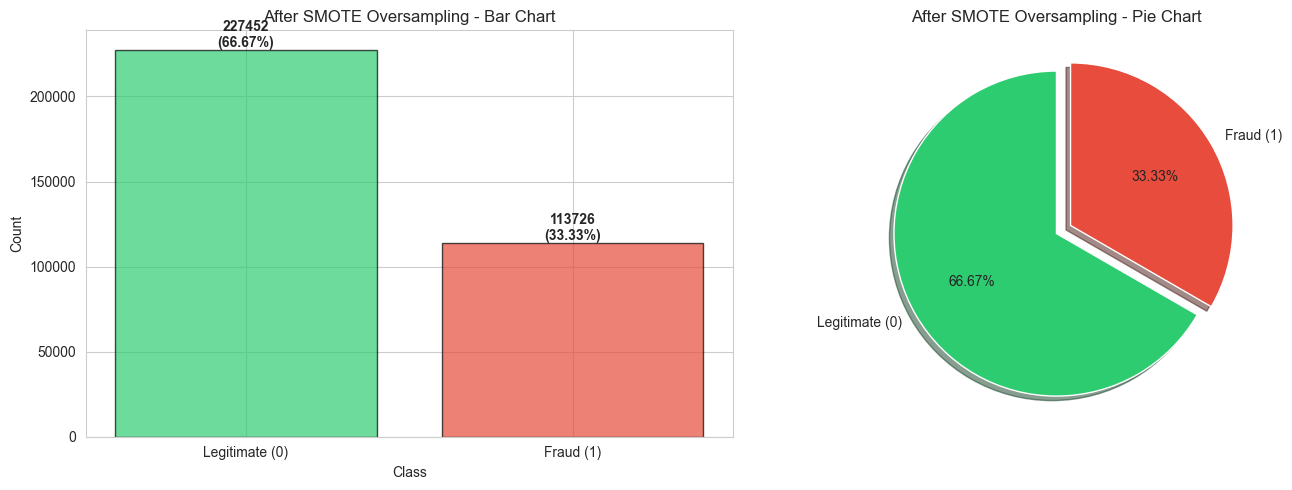

In [11]:
# Visualize SMOTE result
plot_class_distribution(y_train_smote, title="After SMOTE Oversampling")

### 6.3 Random Undersampling

In [12]:
print("=" * 60)
print("OPTION 3: Random Undersampling")
print("=" * 60)
print("\nApplying undersampling with target_ratio=1.0...")
X_train_under, y_train_under = random_undersample(
    X_train, y_train, target_ratio=1.0, random_seed=42
)

print(f"\nNew fraud rate: {y_train_under.sum()/len(y_train_under)*100:.4f}%")

OPTION 3: Random Undersampling

Applying undersampling with target_ratio=1.0...
Original dataset: 227846 samples
Undersampled dataset: 788 samples
New class ratio: 0.5000

New fraud rate: 50.0000%


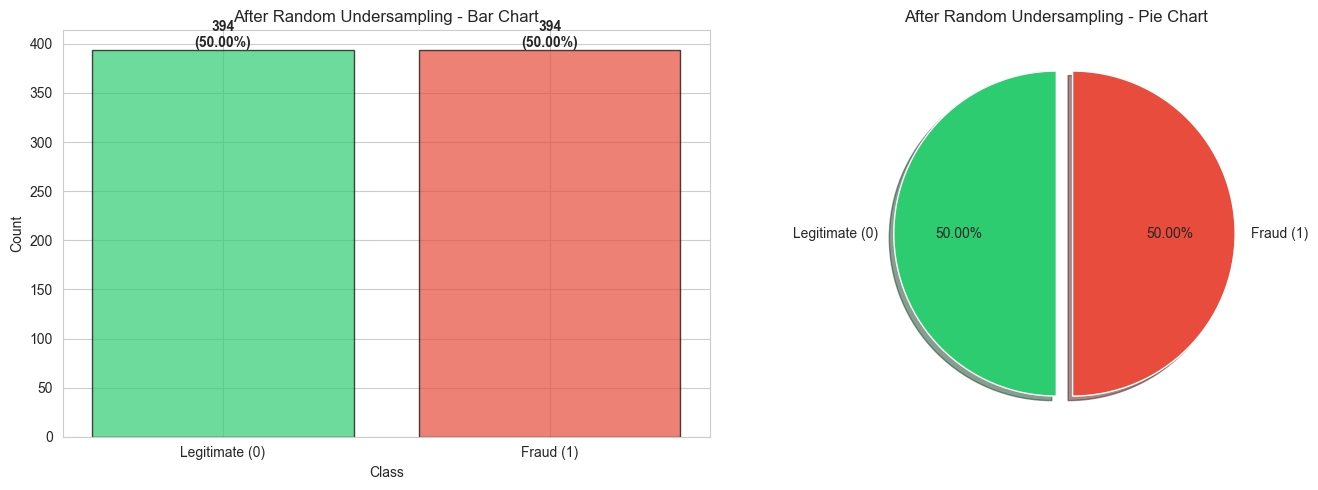

In [13]:
# Visualize undersampling result
plot_class_distribution(y_train_under, title="After Random Undersampling")

### 6.4 Class Weights

In [14]:
print("=" * 60)
print("OPTION 4: Class Weights (No Resampling)")
print("=" * 60)
print("\nComputing class weights...")
class_weights = compute_class_weights(y_train)

print("\nThese weights will be used in the loss function during training.")
print("No modification to the dataset is needed.")

OPTION 4: Class Weights (No Resampling)

Computing class weights...
Class weights: {np.float64(0.0): np.float64(0.5008661168070626), np.float64(1.0): np.float64(289.1446700507614)}

These weights will be used in the loss function during training.
No modification to the dataset is needed.


## 7. Save Processed Data

In [15]:
# Create processed data directory if it doesn't exist
processed_dir = '../data/processed'
os.makedirs(processed_dir, exist_ok=True)

# Save original split (to be used with class weights)
print("Saving processed data...")

np.save(f'{processed_dir}/X_train.npy', X_train)
np.save(f'{processed_dir}/X_test.npy', X_test)
np.save(f'{processed_dir}/y_train.npy', y_train)
np.save(f'{processed_dir}/y_test.npy', y_test)

# Save SMOTE oversampled data
np.save(f'{processed_dir}/X_train_smote.npy', X_train_smote)
np.save(f'{processed_dir}/y_train_smote.npy', y_train_smote)

# Save undersampled data
np.save(f'{processed_dir}/X_train_under.npy', X_train_under)
np.save(f'{processed_dir}/y_train_under.npy', y_train_under)

# Save scaler parameters and class weights
scaler_params['class_weights'] = class_weights
np.save(f'{processed_dir}/scaler_params.npy', scaler_params)

print("\n✓ All processed data saved successfully!")
print(f"\nFiles saved in: {processed_dir}/")

Saving processed data...

✓ All processed data saved successfully!

Files saved in: ../data/processed/


In [16]:
# List saved files
import glob

print("\nSaved files:")
for file in sorted(glob.glob(f'{processed_dir}/*.npy')):
    file_size = os.path.getsize(file) / (1024 * 1024)  # MB
    print(f"  - {os.path.basename(file)} ({file_size:.2f} MB)")


Saved files:
  - X_test.npy (13.04 MB)
  - X_train.npy (52.15 MB)
  - X_train_smote.npy (78.09 MB)
  - X_train_under.npy (0.18 MB)
  - scaler_params.npy (0.00 MB)
  - y_test.npy (0.43 MB)
  - y_train.npy (1.74 MB)
  - y_train_smote.npy (2.60 MB)
  - y_train_under.npy (0.01 MB)


## 8. Summary of Preprocessing

In [17]:
print("=" * 80)
print("PREPROCESSING SUMMARY")
print("=" * 80)

print("\n1. DATA LOADING:")
print(f"   Loaded {len(y):,} transactions")
print(f"   {X.shape[1]} features")

print("\n2. MISSING VALUES:")
print(f"   No missing values detected")

print("\n3. OUTLIER DETECTION:")
print(f"   {outlier_mask_zscore.sum():,} outliers detected (Z-score)")
print(f"   Outliers retained (may contain fraud cases)")

print("\n4. FEATURE SCALING:")
print(f"   Z-score standardization applied")
print(f"   Mean: {X_scaled.mean():.4f}, Std: {X_scaled.std():.4f}")

print("\n5. TRAIN-TEST SPLIT:")
print(f"   Training: {len(y_train):,} samples ({len(y_train)/len(y)*100:.1f}%)")
print(f"   Testing: {len(y_test):,} samples ({len(y_test)/len(y)*100:.1f}%)")
print(f"   Stratified split maintained class distribution")

print("\n6. IMBALANCE HANDLING:")
print(f"   Option 1: Original data with class weights")
print(f"      - Samples: {len(y_train):,}")
print(f"      - Class weights: {class_weights}")
print(f"   Option 2: SMOTE oversampling")
print(f"      - Samples: {len(y_train_smote):,}")
print(f"      - Fraud rate: {y_train_smote.sum()/len(y_train_smote)*100:.2f}%")
print(f"   Option 3: Random undersampling")
print(f"      - Samples: {len(y_train_under):,}")
print(f"      - Fraud rate: {y_train_under.sum()/len(y_train_under)*100:.2f}%")

print("\n7. DATA SAVED:")
print(f"   All processed data saved to {processed_dir}/")

print("\n" + "=" * 80)
print("PREPROCESSING COMPLETE - READY FOR MODELING")
print("=" * 80)

PREPROCESSING SUMMARY

1. DATA LOADING:
   Loaded 284,807 transactions
   30 features

2. MISSING VALUES:
   No missing values detected

3. OUTLIER DETECTION:
   37,816 outliers detected (Z-score)
   Outliers retained (may contain fraud cases)

4. FEATURE SCALING:
   Z-score standardization applied


   Mean: 0.0000, Std: 1.0000

5. TRAIN-TEST SPLIT:
   Training: 227,846 samples (80.0%)
   Testing: 56,961 samples (20.0%)
   Stratified split maintained class distribution

6. IMBALANCE HANDLING:
   Option 1: Original data with class weights
      - Samples: 227,846
      - Class weights: {np.float64(0.0): np.float64(0.5008661168070626), np.float64(1.0): np.float64(289.1446700507614)}
   Option 2: SMOTE oversampling
      - Samples: 341,178
      - Fraud rate: 33.33%
   Option 3: Random undersampling
      - Samples: 788
      - Fraud rate: 50.00%

7. DATA SAVED:
   All processed data saved to ../data/processed/

PREPROCESSING COMPLETE - READY FOR MODELING
